In [1]:
import os
import glob
import numpy as np
import faiss
import torch
import torch.nn as nn
from PIL import Image
# 移除 tqdm，因為載入索引時不需要進度條
# from tqdm import tqdm 
from tqdm import tqdm # 恢復 tqdm，因為提取特徵仍然需要

from torchvision import transforms
from torchvision.models import resnet50

In [2]:
# ==============================================================================
# 0. 環境與路徑設定 (Setup)
# ==============================================================================

# --- 來自 model_pro-50.ipynb 的標準設定 ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 檢索使用的預處理
VAL_TEST_TRANSFORMS = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# ---------------------------------------------

# --- 檔案路徑設定 ---
MODEL_PATH = "advanced_model.pth"
DATABASE_IMAGES_DIR = "deepfashion/images"
FAISS_DB_PATH = "faiss_deepfashion_retrieval_advanced.index"
FEATURE_DIMENSION = 2048

# 用來儲存檔名列表的檔案 (這是新增的，因為 FAISS 不儲存檔名)
INDEXED_NAMES_PATH = "indexed_advanced.npy" 

/opt/conda/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 805: MPS client failed to connect to the MPS control daemon or the MPS server (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# ==============================================================================
# 1. 特徵提取器類別與函式定義
# ==============================================================================

def load_feature_extractor(model_path: str) -> nn.Module:
    """
    載入 pro-50.pth 權重到 ResNet50 模型，並移除最後的分類層。
    """
    print(f"1. 載入模型 ({MODEL_PATH})...")
    model = resnet50(weights=None)
    model.fc = nn.Identity() 

    try:
        state_dict = torch.load(model_path, map_location=DEVICE)
        
        if 'fc.weight' in state_dict:
             state_dict.pop('fc.weight')
             state_dict.pop('fc.bias')
        
        model.load_state_dict(state_dict, strict=False) 
        model.to(DEVICE)
        model.eval() 
        print(f"    ✅ 模型載入完成，輸出特徵維度: {FEATURE_DIMENSION}")
        return model
    except Exception as e:
        print(f"    ❌ 載入模型時發生錯誤。請確保 {MODEL_PATH} 檔案存在。")
        print(f"    錯誤訊息: {e}")
        return None

def get_image_vector(image_path: str, model: nn.Module) -> np.ndarray:
    """
    對單張圖片進行預處理並提取 2048 維特徵向量。
    """
    try:
        image = Image.open(image_path).convert("RGB")
        input_tensor = VAL_TEST_TRANSFORMS(image)
        input_batch = input_tensor.unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            vector = model(input_batch).squeeze(0).cpu().numpy()
            
        return vector.astype('float32')
    except Exception as e:
        return None

In [4]:
# ==============================================================================
# 2. 建立、載入 FAISS 向量資料庫
# ==============================================================================

def load_faiss_index(faiss_path: str, names_path: str) -> tuple:
    """
    載入已儲存的 FAISS 索引和對應的檔名列表。
    """
    try:
        index = faiss.read_index(faiss_path)
        indexed_file_names = np.load(names_path, allow_pickle=True).tolist()
        print(f"\n2. 載入 FAISS 索引成功，索引路徑: {faiss_path}")
        print(f"    ✅ 資料庫圖片數量: {len(indexed_file_names)}")
        return index, indexed_file_names
    except Exception as e:
        print(f"\n2. ❌ 載入 FAISS 索引失敗 (檔案可能遺失或損壞): {e}")
        return None, None

def build_faiss_index(image_dir: str, model: nn.Module) -> tuple:
    """
    遍歷資料庫圖片，提取向量，建立 FAISS 索引並儲存。
    這個函式現在也會儲存圖片檔名列表。
    """
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
    if not image_paths:
        print(f"2. ❌ 在 {image_dir} 中找不到任何圖片 (.jpg)。請檢查路徑。")
        return None, None

    vectors = []
    file_names = []
    
    print(f"\n2. 正在轉換 {len(image_paths)} 張圖片為向量並建立索引...")
    # 使用 tqdm 顯示進度條
    for path in tqdm(image_paths, desc="提取特徵"):
        vector = get_image_vector(path, model)
        if vector is not None and vector.shape[0] == FEATURE_DIMENSION:
            vectors.append(vector)
            file_names.append(os.path.basename(path))

    if not vectors:
        print("    ❌ 未能成功提取任何圖片向量。")
        return None, None
        
    vectors_array = np.array(vectors)

    # 建立 FAISS 索引 (IndexFlatL2)
    print(f"    建立 FAISS 索引，向量數: {vectors_array.shape[0]}, 維度: {FEATURE_DIMENSION}")
    index = faiss.IndexFlatL2(FEATURE_DIMENSION)
    index.add(vectors_array)
    
    # 儲存 FAISS 索引檔
    faiss.write_index(index, FAISS_DB_PATH)
    # 儲存對應的檔名列表 (重要！)
    np.save(INDEXED_NAMES_PATH, np.array(file_names))
    
    print(f"    ✅ FAISS 索引檔已儲存至 {FAISS_DB_PATH}")
    print(f"    ✅ 檔名列表已儲存至 {INDEXED_NAMES_PATH}")

    return index, file_names

In [5]:
# ==============================================================================
# 3. 執行檢索 (Retrieval/Query)
# ==============================================================================

def query_faiss_index(query_image_path: str, model: nn.Module, faiss_index: faiss.Index, indexed_names: list, k: int = 5) -> list:
    """
    使用查詢圖片查找 K 個最相似的資料庫圖片。
    """
    print(f"\n3. 執行向量查詢 (K={k})...")
    if faiss_index is None or indexed_names is None:
        print("    ❌ 向量資料庫尚未建立或載入。")
        return []

    # 1. 取得查詢圖片的向量
    query_vector = get_image_vector(query_image_path, model)
    if query_vector is None:
        print(f"    ❌ 無法提取查詢圖片 {query_image_path} 的向量。")
        return []
    
    # 將查詢向量轉換為 FAISS 期望的 (1, FEATURE_DIMENSION) 格式
    query_vector = query_vector.reshape(1, -1)
    
    # 2. 執行 FAISS 檢索
    D, I = faiss_index.search(query_vector, k)  
    
    # 3. 提取結果
    top_k_results = []
    for rank in range(k):
        index_in_db = I[0][rank]
        distance = D[0][rank]
        
        # 檢查索引是否越界 (雖然通常不會，但作為安全措施)
        if index_in_db >= len(indexed_names):
             continue 

        file_name = indexed_names[index_in_db]
        
        top_k_results.append({
            "rank": rank + 1,
            "file_name": file_name,
            "distance_L2": float(distance) # L2 距離越小越相似
        })
        
    return top_k_results

In [29]:
feature_extractor_model = None
faiss_index = None
indexed_file_names = None

# 1. 載入模型
if os.path.exists(MODEL_PATH):
    feature_extractor_model = load_feature_extractor(MODEL_PATH)
else:
    print(f"❌ 錯誤: 找不到模型檔案 {MODEL_PATH}。請先確認檔案是否存在。")

if feature_extractor_model:
    # 2. 檢查並載入或建立 FAISS 索引
        
    # 檢查索引和檔名列表是否都存在
    if os.path.exists(FAISS_DB_PATH) and os.path.exists(INDEXED_NAMES_PATH):
        faiss_index, indexed_file_names = load_faiss_index(FAISS_DB_PATH, INDEXED_NAMES_PATH)
    else:
        # 如果缺少任一檔案，則需要重建
        if os.path.exists(FAISS_DB_PATH) and not os.path.exists(INDEXED_NAMES_PATH):
            print(f"\n⚠️ 警告: 找到索引檔 {FAISS_DB_PATH}，但缺少檔名列表 {INDEXED_NAMES_PATH}。將重建索引。")
        elif not os.path.exists(FAISS_DB_PATH) and os.path.exists(INDEXED_NAMES_PATH):
            print(f"\n⚠️ 警告: 找到檔名列表 {INDEXED_NAMES_PATH}，但缺少索引檔 {FAISS_DB_PATH}。將重建索引。")
        else:
            print(f"\n2. 索引檔 {FAISS_DB_PATH} 不存在。開始建立新索引...")
            
        faiss_index, indexed_file_names = build_faiss_index(DATABASE_IMAGES_DIR, feature_extractor_model)

# 3. 執行查詢範例
QUERY_IMAGE_EXAMPLE = os.path.join(DATABASE_IMAGES_DIR, "1000_031.jpg") 
#QUERY_IMAGE_EXAMPLE = "tommy_white_T-shirt.jpg"

if faiss_index and os.path.exists(QUERY_IMAGE_EXAMPLE):
    K_COUNT = 5 # 返回 5 個最相似的圖片

    results = query_faiss_index(
        query_image_path=QUERY_IMAGE_EXAMPLE,
        model=feature_extractor_model,
        faiss_index=faiss_index,
        indexed_names=indexed_file_names,
        k=K_COUNT
    )

    print(f"\n========== 查詢結果 (Top {K_COUNT}) ==========")
    print(f"查詢圖片: {os.path.basename(QUERY_IMAGE_EXAMPLE)}")
    for r in results:
        print(f"Rank {r['rank']}: {r['file_name']} (L2 距離: {r['distance_L2']:.4f})")
    print("==========================================")
elif faiss_index and not os.path.exists(QUERY_IMAGE_EXAMPLE):
    print(f"\n❌ 錯誤: 範例查詢圖片路徑不存在: {QUERY_IMAGE_EXAMPLE}")
# elif not feature_extractor_model:
    # 錯誤訊息已在上面處理
else:
    print("\n❌ 無法執行查詢，因為模型或索引載入失敗。")

1. 載入模型 (advanced_model.pth)...
    ✅ 模型載入完成，輸出特徵維度: 2048

2. 載入 FAISS 索引成功，索引路徑: faiss_deepfashion_retrieval_advanced.index
    ✅ 資料庫圖片數量: 13752

3. 執行向量查詢 (K=5)...

========== 查詢結果 (Top 5) ==========
查詢圖片: 1000_031.jpg
Rank 1: 5129_102.jpg (L2 距離: 1426034.6250)
Rank 2: 2808_082.jpg (L2 距離: 1521208.7500)
Rank 3: 3497_012.jpg (L2 距離: 1558141.2500)
Rank 4: 1186_012.jpg (L2 距離: 1584025.5000)
Rank 5: 5113_041.jpg (L2 距離: 1653625.5000)



4. 正在準備視覺化查詢結果...


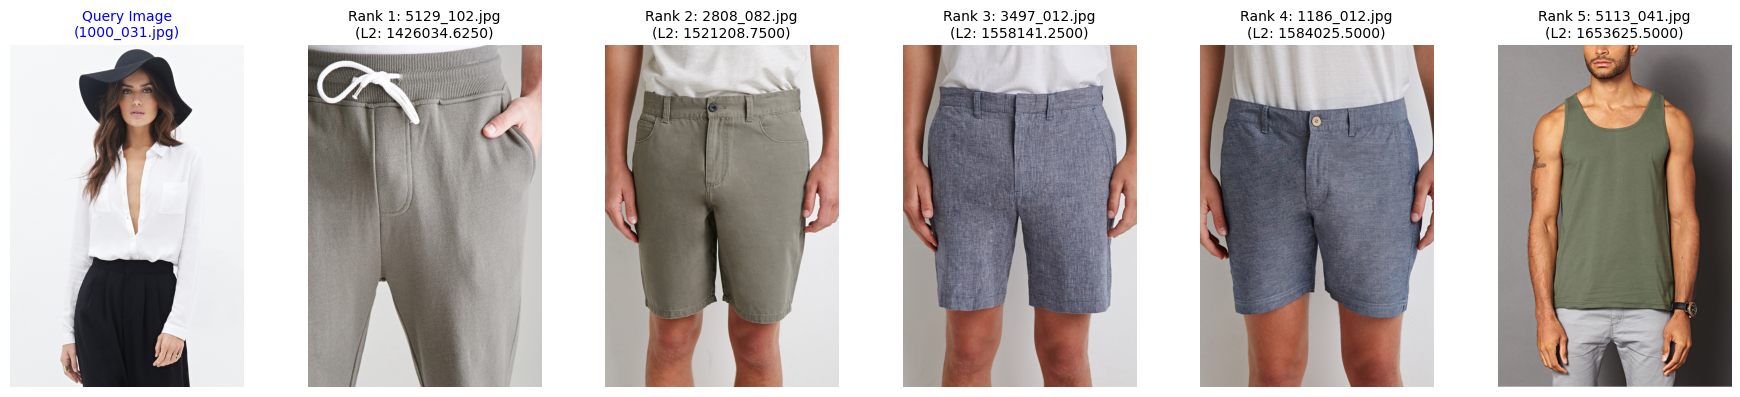

In [30]:
# ==============================================================================
# 5. 圖片視覺化區塊 (Visualization Block)
# ==============================================================================

if faiss_index and os.path.exists(QUERY_IMAGE_EXAMPLE) and results:
    try:
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        
        K_COUNT = len(results)
        
        # 建立一個包含 K_COUNT + 1 張圖片的畫布
        fig, axes = plt.subplots(1, K_COUNT + 1, figsize=(3 * (K_COUNT + 1), 4))
        
        # --- 顯示查詢圖片 (第一張) ---
        query_img = mpimg.imread(QUERY_IMAGE_EXAMPLE)
        axes[0].imshow(query_img)
        axes[0].set_title(f"Query Image\n({os.path.basename(QUERY_IMAGE_EXAMPLE)})", 
                          color='blue', fontsize=10)
        axes[0].axis('off')

        print("\n4. 正在準備視覺化查詢結果...")

        # --- 顯示檢索到的 K 張圖片 ---
        for i, r in enumerate(results):
            # 圖片在資料庫中的完整路徑
            img_path = os.path.join(DATABASE_IMAGES_DIR, r['file_name'])
            
            # 確保圖片存在
            if os.path.exists(img_path):
                retrieved_img = mpimg.imread(img_path)
                
                # 在第 i+1 個位置顯示圖片
                axes[i + 1].imshow(retrieved_img)
                axes[i + 1].set_title(
                    f"Rank {r['rank']}: {r['file_name']}\n(L2: {r['distance_L2']:.4f})",
                    fontsize=10
                )
                axes[i + 1].axis('off')
            else:
                # 如果圖片檔案遺失，顯示錯誤提示
                axes[i + 1].set_title(f"Rank {r['rank']}: Image Not Found", color='red')
                axes[i + 1].axis('off')

        plt.tight_layout()
        plt.show() # 在 Notebook/Colab 中顯示圖片
        
    except ImportError:
        print("\n⚠️ 警告: 找不到 'matplotlib' 庫。請安裝：'pip install matplotlib' 以視覺化結果。")
    except Exception as e:
        print(f"\n❌ 視覺化圖片時發生錯誤: {e}")

# ==============================================================================